
### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300"> 🩺 Notebook At a Glance</p>

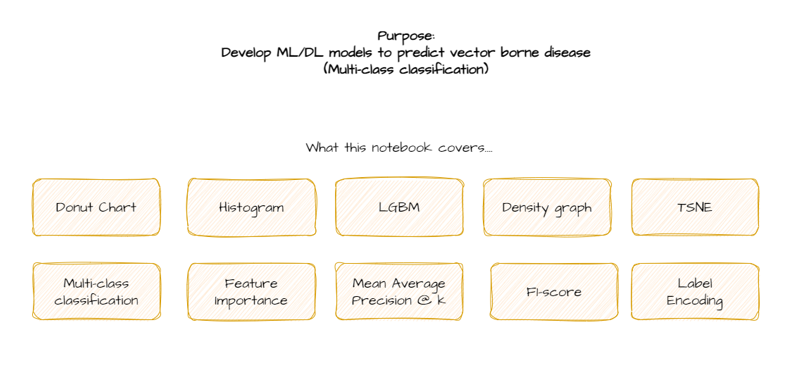

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
import seaborn as sns
import gc
import re as re
from collections import Counter

from tqdm.auto import tqdm
import math
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import warnings
warnings.filterwarnings('ignore')

import time
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
%matplotlib inline
tqdm.pandas()

rc = {
    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

pd.set_option('display.max_rows', 100)

In [2]:
train = pd.read_csv('./Data/enfermedades/train.csv')
test = pd.read_csv('./Data/enfermedades/test.csv')
original = pd.read_csv('./Data/enfermedades/train.csv')

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">📊 EDA</p>

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>📊 EDA summary:</font></h3>

* There are 66 variables with 1 identification varaible(id) and 1 target variable.
* All X variables are sympotom data (float64 type) with no missing value!
* All symptoms and Prognosis included associated with 11 Vector Borne Diseases.
 - Chikungunya
 - Dengue
 - Zika
 - Yellow Fever
 - Raft Valley Fever
 - West Nile Fever
 - Malaria
 - Tungiasis
 - Japanese Encephalitis
 - Plague
 - Lyme Disease


In [3]:
# summary table function
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [4]:
summary(train)

data shape: (707, 66)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
id,int64,0,0.0,707,0.0,706.0,0,1,2
sudden_fever,float64,0,0.0,2,0.0,1.0,1.0,0.0,0.0
headache,float64,0,0.0,2,0.0,1.0,1.0,0.0,1.0
mouth_bleed,float64,0,0.0,2,0.0,1.0,0.0,0.0,1.0
nose_bleed,float64,0,0.0,2,0.0,1.0,1.0,0.0,1.0
muscle_pain,float64,0,0.0,2,0.0,1.0,1.0,0.0,0.0
joint_pain,float64,0,0.0,2,0.0,1.0,1.0,0.0,1.0
vomiting,float64,0,0.0,2,0.0,1.0,1.0,1.0,1.0
rash,float64,0,0.0,2,0.0,1.0,0.0,0.0,1.0
diarrhea,float64,0,0.0,2,0.0,1.0,1.0,1.0,1.0


In [5]:
# select X variables
all_cols = test.select_dtypes(include=['float64','int64']).columns.tolist()
all_cols.remove('id')

In [6]:
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)  
fig2 = px.pie(train, names='prognosis', 
             height=450, width=600, 
             hole=0.7, 
             title='Prognosis Overview',
                   color_discrete_sequence=['#4c78a8', '#72b7b2'])
fig2.update_traces(hovertemplate=None, textposition='outside', textinfo='percent+label', rotation=0)
fig2.update_layout(margin=dict(t=100, b=30, l=0, r=0), showlegend=False,
                        plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                        title_font=dict(size=20, color='#555', family="Lato, sans-serif"),
                        font=dict(size=14, color='#8a8d93'),
                        hoverlabel=dict(bgcolor="#444", font_size=13, font_family="Lato, sans-serif"))
fig2.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

* This is a balanced multi classification dataset.
* West Nile Fever accounts for 12% while Malaria only accounts for 6.79%.
* Overall, however, this dataset can be considered as balanced multi-class dataset.

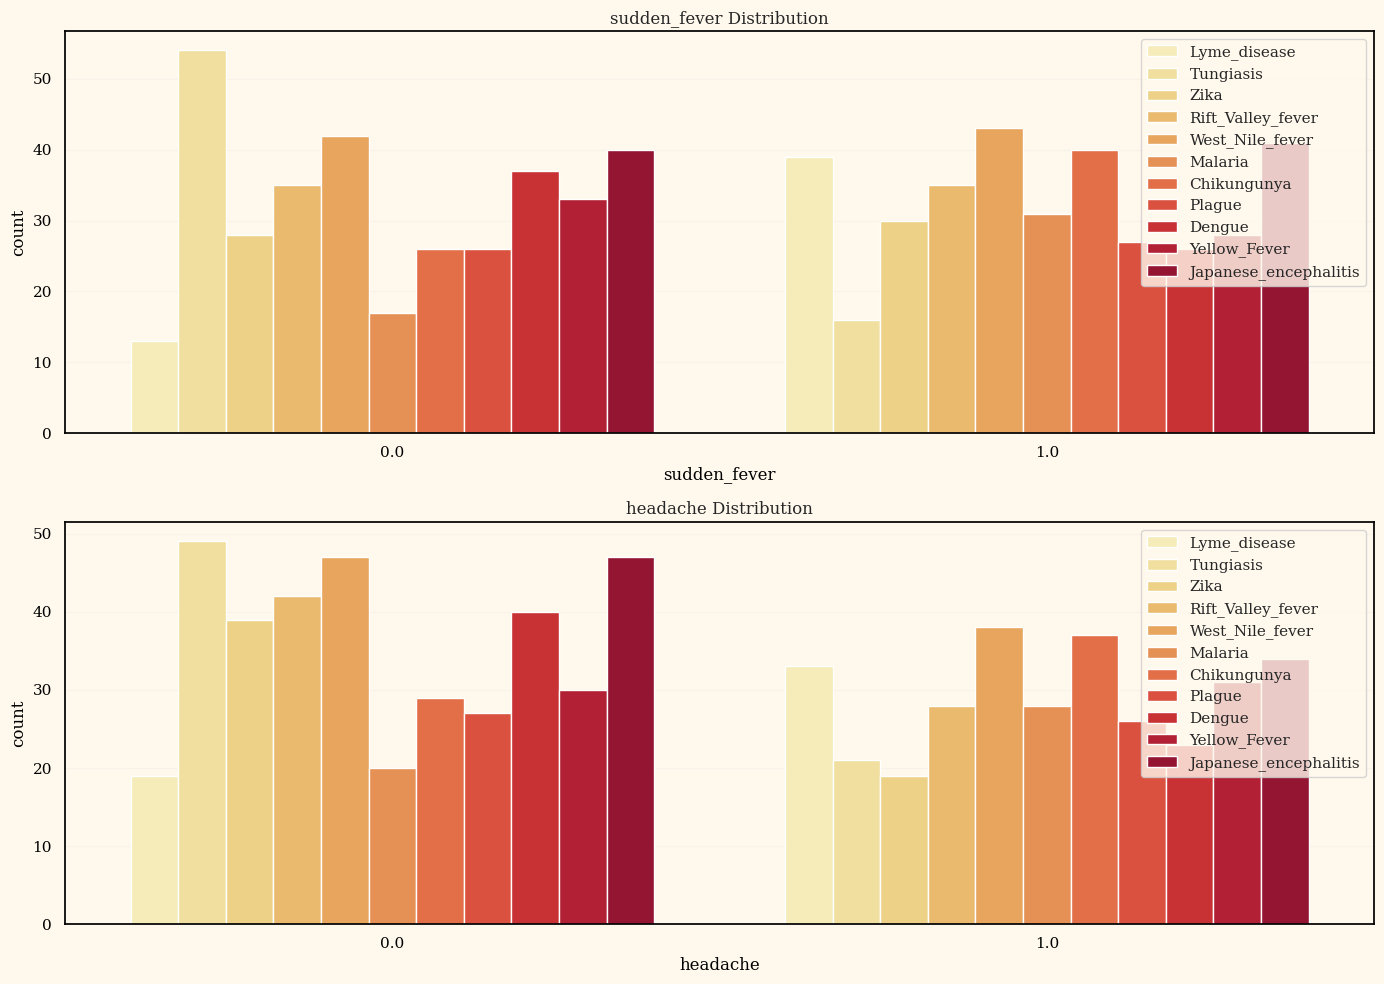

In [7]:
plt.figure(figsize=(14,10))
for idx,column in enumerate(all_cols[:2]):
    plt.subplot(2,1,idx+1)
    sns.countplot(x=column, hue="prognosis", data=train, palette="YlOrRd")
    plt.title(f"{column} Distribution")
    plt.legend(loc = 'upper right', bbox_to_anchor = (1, 1))
    plt.tight_layout()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

* As there are many X variables (64), I only select 2 variables to show distribution.

* The distribution is different obviously, which means these variables have predictive power in some sense.

* For example, sudden fever distribution is differt by disease type. 
    

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

* Some of sympotoms are highly correlated. Common sense tells us that some sysmpotoms occurs at the same time.

#### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">🛠 Modeling</p>

In [8]:
# as our target variables is categorical with string, we need to convert it to numeric.
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label = le.fit_transform(train['prognosis'])

In [9]:
y = label
X = train[all_cols]

> #### check dimensionality reduction methos (for illustration purpose only)

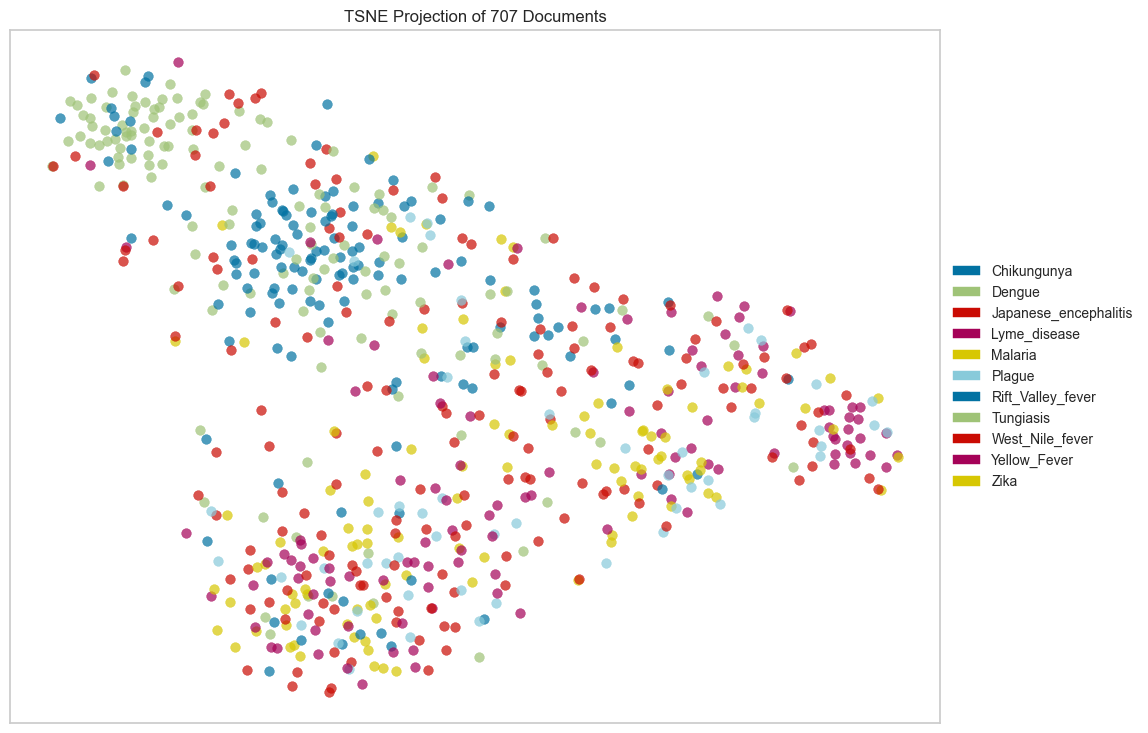

<Axes: title={'center': 'TSNE Projection of 707 Documents'}>

In [10]:
from yellowbrick.text import TSNEVisualizer
# Create the visualizer and draw the vectors
plt.figure(figsize = [15,9])
tsne = TSNEVisualizer()
tsne.fit(X, train['prognosis'])
tsne.poof()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes:</font></h3>

* As there are many X variables, we can consider dimensionality reduction method like t-SNE.
    
* We are not gonna use this method in this notebook.

In [11]:
import lightgbm as lgb

# split dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1004)

#Converting the dataset in proper LGB format
d_train=lgb.Dataset(X_train, label=y_train)
#setting up the parameters
params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=8
params['num_class']=11 #no.of unique values in the target class not inclusive of the end value
params['verbose']=-1
#training the model
clf=lgb.train(params,d_train,1000)  #training the model on 1,000 epocs
#prediction on the test dataset
y_pred_1=clf.predict(X_test)
clf.save('model-clasificacion-enfermedades')

In [12]:
y_pred_1[:1]

array([[1.40987558e-04, 3.47971149e-02, 1.73632145e-01, 6.84841033e-02,
        3.50286295e-02, 2.09986925e-02, 1.74628836e-01, 2.07326463e-04,
        4.16841697e-02, 4.44910315e-01, 5.48767967e-03]])

> #### As you can see, it predict the probability of each disease type. We need to select top 3 disease and compare it with actual value!

> #### Evalution: please note that the evaluation metric is Mean Average Precision @ K! I check F-score for illustration purpose.

In [13]:
# check F-score (macro) for test purpose
from sklearn.metrics import f1_score
f1_score(y_test,np.argmax(y_pred_1, axis=-1), average='macro')

0.23011338172628495

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes:</font></h3>

* Please remember that the evaluation metric is Mean Average Precision @ K! Unlike many multiclass classification metrics, MAP@K permits the evaluation of multiple predictions for a single row. It's often used for reccomendation systems, where multiple results are recommended, but also makes sense for our vector borne disease problem, as narrowing possible diagnoses down to 2 or 3 might allow us to efficiently run additional tests to arrive at a final diagnosis.

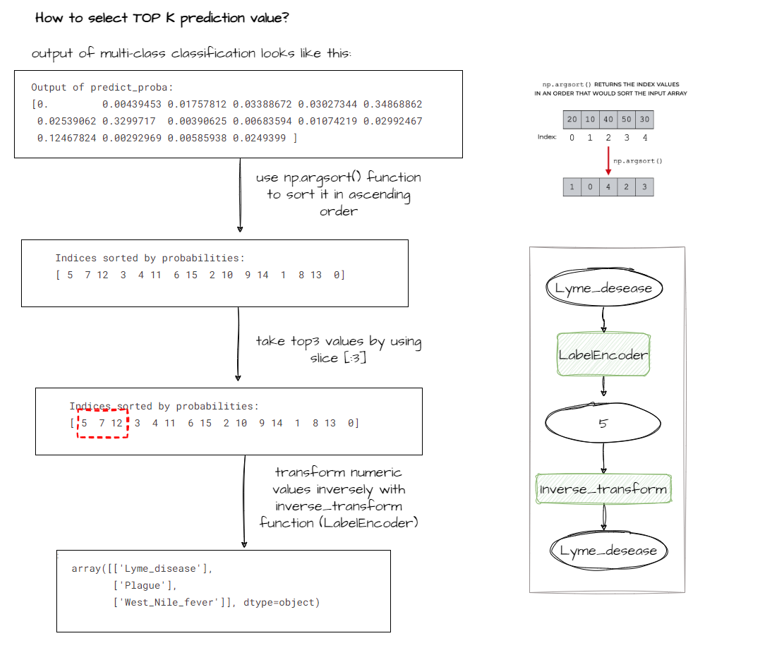

In [14]:
def apk(actual, predicted, k=11):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if not actual:
        return 0.0

    if len(predicted)>=k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        # first condition checks whether it is valid prediction
        # second condition checks if prediction is not repeated
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(actual), k)

def mapk(actual, predicted, k=11):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [15]:
sorted_pred_idx = np.argsort(-y_pred_1, axis=1)[:,:3]
original_shape = sorted_pred_idx.shape
top3_pred = le.inverse_transform(sorted_pred_idx.reshape(-1,1))
top3_pred = top3_pred.reshape(original_shape)

In [16]:
#let's check 10 rows of predicted values
top3_pred[:10]

array([['Yellow_Fever', 'Rift_Valley_fever', 'Japanese_encephalitis'],
       ['Zika', 'West_Nile_fever', 'Tungiasis'],
       ['Yellow_Fever', 'Plague', 'Japanese_encephalitis'],
       ['Lyme_disease', 'Malaria', 'Yellow_Fever'],
       ['Chikungunya', 'Malaria', 'Yellow_Fever'],
       ['Tungiasis', 'Rift_Valley_fever', 'Dengue'],
       ['Chikungunya', 'Rift_Valley_fever', 'Tungiasis'],
       ['Japanese_encephalitis', 'West_Nile_fever', 'Plague'],
       ['Japanese_encephalitis', 'West_Nile_fever', 'Plague'],
       ['Zika', 'Yellow_Fever', 'Tungiasis']], dtype=object)

In [17]:
# let's see mean average precision score
mapk(y_test.reshape(-1, 1), sorted_pred_idx, k=3)

0.28638497652582157

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes:</font></h3>

* Of course, mean average precision @top3 is higher than it's precision @ top1. But still have a room for improvement:
    - feature engineering is necessary as there are more than 50 variables (considering sample size, it's high dimension)
    - hyper-parameter tuning is needed (with CV methods)
    - you can add original data set :)